In [ ]:
#Agregamos celda nuevo para uso de imagenes + labels txt
from torch.utils.data import Dataset
from PIL import Image
import os

class YOLOClassificationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        label_path = os.path.join(self.labels_dir, img_file.replace(".jpg", ".txt"))
        
        # Cargar imagen
        image = Image.open(img_path).convert("RGB")
        
        # Leer etiqueta (primer número del archivo txt)
        with open(label_path, "r") as f:
            first_line = f.readline().strip()
            class_id = int(first_line.split()[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_id


In [ ]:
# Ejemplo de uso
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = YOLOClassificationDataset(
    images_dir="../../datasets/processed/images/train/images",
    labels_dir="../../datasets/processed/images/train/labels",
    transform=transform
)

img, label = train_dataset[0]
print("Clase:", label)
print("Imagen tensor shape:", img.shape)

Clase: 0
Imagen tensor shape: torch.Size([3, 128, 128])


***Iniciación de entrenamiento de modelo***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
#Dataset personalizado
class YOLOClassificationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        label_path = os.path.join(self.labels_dir, img_file.replace(".jpg", ".txt"))
        
        # Cargar imagen
        image = Image.open(img_path).convert("RGB")
        
        # Leer etiqueta
        with open(label_path, "r") as f:
            first_line = f.readline().strip()
            class_id = int(first_line.split()[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_id

In [ ]:
# Configuración
data_dir = "../../datasets/processed/images"
img_size = 128
batch_size = 32
epochs = 5
lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets
train_dataset = YOLOClassificationDataset(
    images_dir=f"{data_dir}/train/images",
    labels_dir=f"{data_dir}/train/labels",
    transform=transform
)

val_dataset = YOLOClassificationDataset(
    images_dir=f"{data_dir}/val/images",
    labels_dir=f"{data_dir}/val/labels",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)} imágenes")
print(f"Val: {len(val_dataset)} imágenes")

Usando dispositivo: cpu
Train: 1468 imágenes
Val: 164 imágenes


In [ ]:
# Modelo CNN simple
class CNNBaseline(nn.Module):
    def __init__(self, num_classes=2):  #ajusta num_classes según tu dataset
        super(CNNBaseline, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * (img_size//4) * (img_size//4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ⚠️ Cambia num_classes al número real de clases
model = CNNBaseline(num_classes=2).to(device)
print(model)

CNNBaseline(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
#Perdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Entrenamiento
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.6735
Epoch 2/5, Loss: 0.6675
Epoch 3/5, Loss: 0.6631
Epoch 4/5, Loss: 0.6477
Epoch 5/5, Loss: 0.6201


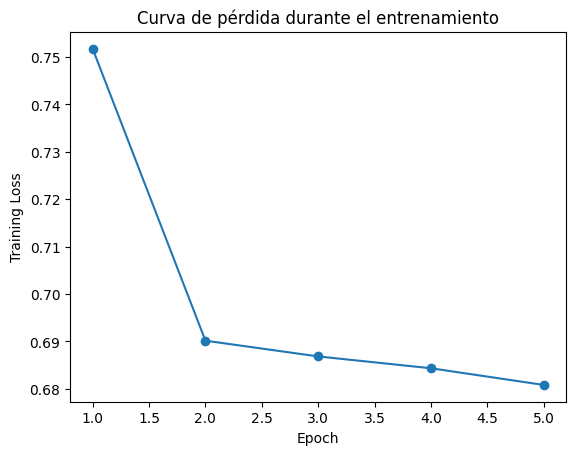

In [ ]:
# Gráficar la pérdida de entrenamiento
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Curva de pérdida durante el entrenamiento")
plt.show()

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), "../../models/saved/cnn_baseline.pth")
print("✅ Modelo guardado en: ../../models/saved/cnn_baseline.pth")

✅ Modelo guardado en: ../../models/saved/cnn_baseline.pth
